In [1]:
import pandas as pd
import numpy as np

import cv2 as cv
# from sklearn.preprocessing import LabelEncoder
import pickle
from keras_facenet import FaceNet
from mtcnn.mtcnn import MTCNN
from PIL import Image
from datetime import datetime

In [2]:
with open("../packages/model.pkl", 'rb') as f:
    model = pickle.load(f)
with open("../packages/encoder.pkl", 'rb') as f:
    encoder = pickle.load(f)

In [3]:
detector = MTCNN()
embedder = FaceNet()
# faces_embeddings = np.load("embeddings.npz")
# Y = faces_embeddings['labels']
threshold = 0.6

In [4]:
def get_embeddings(face_img):
    face_img = np.expand_dims(face_img, axis=0)
    embedding = embedder.embeddings(face_img)
    embedding = embedding[0]
    return embedding

In [5]:
def load_image(image_path):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    return image

In [6]:
def extract_faces(img):
    img = load_image(img)
    faces = detector.detect_faces(img)
    embeddings = []
    boxes = []
    if faces:
        for face in faces:
            box = face['box']
            x, y, w, h = box
            face_img = img[y:y+h, x:x+w]
            face_img = cv.resize(face_img, (160, 160))
            embedding = get_embeddings(face_img)
            embeddings.append(embedding)
            boxes.append(box)
    return embeddings, boxes

In [7]:
def predict(image):
    embeddings, boxes = extract_faces(image)
    predictions = []
    if embeddings:
        for embedding in embeddings:
            proba = model.predict_proba(embedding.reshape(1, -1))
            max_proba = np.argmax(proba)
            if proba[0][max_proba] > threshold:
                predictions.append(encoder.inverse_transform([max_proba])[0])
            else:
                print("Unknown")
                predictions.append("Unknown")   
    return predictions, boxes

In [8]:
def attendance(df, path):
    predictions, boxes = predict(path)
    for prediction in predictions:
        if prediction in df["Name"].values:
            now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            df.loc[df['Name'] == prediction, 'Attendance'] = 'present'
            df.loc[df['Name'] == prediction, 'Time'] = now
        else:
            print("Data Tidak Ditemukan")
    return df, predictions, boxes

In [9]:
df = pd.DataFrame({
        'Name': ["Aditya", "Elon Musk", "Fitriah"],
        'Attendance': [""] * 3,
        'Time': [""] * 3
    })

In [10]:
path = "../testing.jpg"
df, predictions, boxes = attendance(df, path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Unknown
Unknown
Data Tidak Ditemukan
Data Tidak Ditemukan


In [11]:
import matplotlib.pyplot as plt

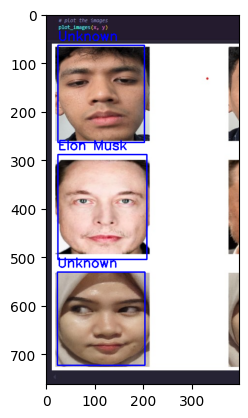

In [12]:
img = load_image(path)
for (box, prediction) in zip(boxes, predictions):
    x, y, w, h = box
    cv.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    cv.putText(img, prediction, (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
plt.imshow(img)

In [28]:
df.head()

,Name,Attendance,Time
0,Aditya,present,2024-06-12 15:01:36
1,Elon Musk,present,2024-06-12 15:01:36
2,Fitriah,present,2024-06-12 15:01:36
